# Import Libraries, OpenAI-, Bibtex- and Database-Info

In [2]:
import os
import shutil
from PyPDF2 import PdfReader
import re
import mariadb
import openai
from difflib import SequenceMatcher
import nltk
nltk.download('punkt')
from grobid_client.grobid_client import GrobidClient
from bs4 import BeautifulSoup
import arxiv

[nltk_data] Downloading package punkt to
[nltk_data]     /home/stefan_reifberger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
pdf_folder = '/home/stefan_reifberger/Documents/Studies_and_Research/Literature'
pdf_folder_whole_parsing = 'Literature'
pdf_folder_temporary = 'PDF'
xml_folder = "./XML" 

# Texts, Sentences and Tokens Table

## Definitions for Parsing Bibliographies 

## Fill Content- and Metadatatable From Initial Entries and Repeat 

In [4]:
def delete_redundant_entries():
  sql="""DELETE FROM authors
  WHERE LENGTH(forename) = 1 
    AND EXISTS (
      SELECT 1 FROM authors AS t2 
      WHERE t2.surname = authors.surname 
        AND LENGTH(t2.forename) > 1 
        AND t2.forename LIKE CONCAT(authors.forename, '%')
    )"""

  cursor.execute(sql)
  conn.commit()

In [5]:
def build_bibtex(part, authors, text_id, title_text, title_above, date, bib_type):
    volume = ""
    journal_booktitle_bib_part = ""
    address_part = ""
    volume_bib_part = ""
    editor_bib_part = ""
    address_bib_part = ""
    pages_bib_part = ""
    publisher_bib_part = ""
    url_bib_part = ""
    pages = ""
    try:
        volume_part = part.find(unit="volume")
        volume = volume_part.get_text()
    except Exception as e:
        pass
    try:
        part_pages= part.find(unit="page")
        pages_start = part_pages.get('from')
        pages_end = part_pages.get('to')
        pages =f"{pages_start}--{pages_end}" 
    except Exception as e:
        pass
    try:
        editor_part = part.editor
        editor = editor_part.get_text()
        editor = editor.strip()
        editor_bib_part = f", editor={{{editor}}}"
    except Exception as e:
        pass
    try:
        publisher_part = part.publisher
        publisher = publisher_part.get_text()
    except Exception as e:
        pass
    try:
        address_part = part.address
        address = address_part.get_text()
    except Exception as e:
        pass
    if bib_type == "article":
        journal_booktitle = title_above
        journal_booktitle_bib_part = f", journal={{{journal_booktitle}}}"
        volume_bib_part = f", volume={{{volume}}}"
        pages_bib_part = f", pages={{{pages}}}"
    else:
        if bib_type == "incollection":
            journal_booktitle = title_above
            journal_booktitle_bib_part = f", book={{{journal_booktitle}}}"
            pages_bib_part = f", pages={{{pages}}}"
        else:
            try:
                bib_type == "book"
                publisher_bib_part = f", publisher={{{publisher}}}"
                address_bib_part = f", address={{{address}}}"
            except Exception as e:
                pass
    bibtex = f"@{bib_type}{{{text_id}, author={{{authors[:-5]}}}, title={{{title_text}}}{journal_booktitle_bib_part}{address_bib_part}{volume_bib_part}{editor_bib_part}{pages_bib_part}{publisher_bib_part}{url_bib_part}, year={{{date[:4]}}},}}"

    return bibtex

In [6]:
def author_year_title_from_header_to_table_authors_and_texts(part, text_id, year_from_id):
    try:
        text_id_cites = text_id
        author_elements = part.find_all('author')
        author_list = []
        author_id_list = []
        authors = ""
        for e in author_elements:
            surname_span = e.surname
            surname = surname_span.get_text()
            author_list.append(surname)
            forename_span = e.forename
            forename = forename_span.get_text()
            authors = f"{surname}, {forename} and "
            try:
                sql = f"INSERT INTO authors (surname, forename) VALUES ('{surname}','{forename}')"
                cursor.execute(sql)
                conn.commit()
                cursor.execute("SELECT author_id FROM authors ORDER BY author_id DESC LIMIT 1")
                author_id = cursor.fetchone()[0]
                author_id_list.append(author_id) 
            except Exception as e:
                continue
        year_part = part.date
        date = year_part.get_text()
        if len(year_from_id) > 0:
            date = year_from_id
        title_j = ""
        title_a = ""
        title_m = ""
        title_text = ""
        title_above = ""
        title_parts = part.find_all('title')
        for e in title_parts:
            title_level = e.get('level')
            if title_level == 'j':
                title_j = e.get_text()
            if title_level == 'a':
                title_a = e.get_text()
            if title_level == 'm':
                title_m = e.get_text()
        if len(title_j) > 0:
            title_text = title_a
            title_above = title_j
            bib_type = "article"
        else:
            if len(title_a) > 0:
                title_text = title_a
                title_above = title_m
                bib_type = "incollection"
            else:
                title_text = title_m
                bib_type = "book"
        author_for_id = re.sub(" +", "", author_list[0])
        title_list = title_text.split()
        text_id = f"{author_for_id}_{date[:4]}_{title_list[0]}"
        for id in author_id_list:
            sql = f"INSERT INTO author_of (author_id, text_id) VALUES ('{id}','{text_id}')"
            cursor.execute(sql)
            conn.commit()
        for char in [',',':']:
            text_id = text_id.replace(char, '')
        bibtex = ""
        try:
            bibtex = build_bibtex(part, authors, text_id, title_text, title_above, date, bib_type)
        except Exception as e:
            pass
        try:
            sql = f"INSERT INTO texts (text_id, year, title, bibtex) VALUES ('{text_id}','{date[:4]}','{title_text}','{bibtex}')"
            cursor.execute(sql)
            conn.commit()
        except Exception as e:
            pass
        if len(text_id_cites) > 0:
            try:
                sql = f"INSERT INTO citations (text_id_cites, text_id_cited) VALUES ('{text_id_cites}','{text_id}')"
                cursor.execute(sql)
                conn.commit()
            except Exception as e:
                print(e)
    except Exception as e:
        pass

In [7]:
def tokens_to_table_tokens(soup, text_id):
    body_part = soup.body
    sentence_elements = body_part.find_all('s')
    for s in sentence_elements:
        sentence = s.get_text()
        try:
            sql = f"INSERT INTO sentences (sentence, text_id) VALUES ('{sentence}','{text_id}')"
            cursor.execute(sql)
            conn.commit()
            query = "SELECT sentence_id FROM sentences ORDER BY sentence_id DESC LIMIT 1"
            cursor.execute(query)
            # Fetch the result
            result = cursor.fetchone()

            # Extract the value from the result
            if result:
                sentence_id = result[0]
            token_elements = sentence.split()
            for token in token_elements:
                sql = f
    # Get all rows from the new"INSERT INTO tokens (token, sentence_id, text_id) VALUES ('{token}','{sentence_id}','{text_id}')"
                cursor.execute(sql)
                conn.commit()
        except Exception:
            continue
    reference_part = soup.find('listBibl')
    reference_elements = reference_part.find_all('biblStruct')
    for part in reference_elements:
        year_from_id = ""
        author_year_title_from_header_to_table_authors_and_texts(part, text_id, year_from_id)

In [8]:
def whole_pdf_to_tables(text_id, pdf_folder, surname, forename, year, title):
    xml_list = []
    # Algorithm that searches for text via text id, first among XMLs, then among PDFs
    for id in text_id:
        id_found = False
        try:
            # Search XML
            for filename in os.listdir(xml_folder):
                if filename.startswith(id):
                    filepath = os.path.join(xml_folder, filename)
                    xml_list.append(filepath)
                    id_found = True
            # Search PDF
            if id_found == False:
                for filename in os.listdir(pdf_folder):
                    if filename.startswith(id):
                        filepath = os.path.join(pdf_folder, filename)
                        filepath_b = os.path.join(pdf_folder_temporary, filename)
                        xml_list.append(f'{xml_folder}/{filename[:-4]}.tei.xml')
                        shutil.copy(filepath,filepath_b)
                        id_found = True
            if id_found == False:
                paper = next(arxiv.Search(query = f"au:{surname}_{forename} AND ti:{title}").results())
                filename = f"{surname}_{year}_{title}.pdf"
                paper.download_pdf(dirpath=pdf_folder, filename=filename)
                print(f"Downloading {filename} from Arxiv.")
                filepath = os.path.join(pdf_folder, filename)
                filepath_b = os.path.join(pdf_folder_temporary, filename)
                xml_list.append(f'{xml_folder}/{filename[:-4]}.tei.xml')
                shutil.copy(filepath,filepath_b)
                id_found = True
        except Exception as e:
            print(e)
            
    # Convert PDFs to XML and delete them again from temporary folder, if PDFs where sought in last step
    if len(os.listdir(pdf_folder_temporary)) > 0:
        try:   
            client = GrobidClient(config_path="./config.json")
            client.process("processFulltextDocument", pdf_folder_temporary, output=xml_folder, segment_sentences=True, n=20)
        except Exception as e:
            print("Grobid could not get xml.")
        try:
            for filename in os.listdir(pdf_folder_temporary):
                filepath = os.path.join(pdf_folder_temporary, filename)
                os.remove(filepath)
        except Exception as e:
            print("Deletion of PDFs failed.")
            
    # Fill texts table
    for xml_path in xml_list:
        try:
            with open(xml_path, 'r') as tei:
                print(f"Processing {xml_path}")
                for id in text_id:
                    if id in xml_path:
                        text_id = id
                        year_from_id = re.search(r"\d{4}", text_id)
                soup = BeautifulSoup(tei, 'xml')
                part = soup.teiHeader
                author_year_title_from_header_to_table_authors_and_texts(part, text_id, year_from_id)
                tokens_to_table_tokens(soup, text_id)
        except Exception as e:
            continue
    return xml_list

In [14]:
conn = mariadb.connect(
    user="root",
    password="sr",
    host="localhost",
    database="corpora",
    port=3306
)
cursor = conn.cursor()

# Loop through the new table until all PDF files are found
iteration_count = 0
xml_list = ["start"]

#while len(xml_list) > 0:
while iteration_count < 2:
    # Get all rows from the new table where the PDF has not been found yet
    cursor.execute('SELECT COUNT(*) FROM texts')
    result = cursor.fetchone()

    if result[0] == 0:
        text_id = ["Romeijn_2022_Philosophy"]
        surname = ""
        forename = ""
        year = ""
        title = ""
        whole_pdf_to_tables(text_id, pdf_folder, surname, forename, year, title)
        xml_list = whole_pdf_to_tables(text_id, pdf_folder, surname, forename, year, title)
    else:
        cursor.execute('SELECT * FROM texts WHERE text_id NOT IN (SELECT text_id FROM sentences)')
        rows = cursor.fetchall()
        for row in rows:
            try:
                text_id = [row[0]]
                year = row[1]
                title = row[2]
                cursor.execute(f"SELECT * FROM authors WHERE author_id IN (SELECT author_id FROM author_of WHERE text_id = '{text_id[0]}') AND '{text_id[0]}' LIKE CONCAT('%', surname, '%')")
                name_rows = cursor.fetchall()
                name_row = name_rows[0]
                surname = name_row[0]
                forename = name_row[1]
                whole_pdf_to_tables(text_id, pdf_folder, surname, forename, year, title)
                xml_list = whole_pdf_to_tables(text_id, pdf_folder, surname, forename, year, title)
            except Exception as e:
                print(f"Exception: {e}")
    print(f"Iteration of program: {iteration_count}")
    iteration_count += 1

delete_redundant_entries()
conn.close()

GROBID server is up and running
Processing ./XML/Romeijn_2022_Philosophy of Statistics (Stanford Encyclopedia of Philosophy).tei.xml
Processing ./XML/Romeijn_2022_Philosophy of Statistics (Stanford Encyclopedia of Philosophy).tei.xml
You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near 's')' at line 1
Iteration of program: 0
GROBID server is up and running
Processing ./XML/Aldous_1981_Representations for Partially Exchangeable Arrays of Random Variables.tei.xml
Processing ./XML/Aldous_1981_Representations for Partially Exchangeable Arrays of Random Variables.tei.xml
You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near 's')' at line 1




Exception: list index out of range






Exception: list index out of range
Exception: list index out of range
GROBID server is up and running
Processing ./XML/Berger_2006_The Case for Obj

## Fill Content- and Metadatatable From Folder 

In [ ]:
conn = mariadb.connect(
    user="root",
    password="sr",
    host="localhost",
    database="corpora",
    port=3306
)

cursor = conn.cursor()
xml_list = []
pdf_sought = False
# Algorithm that searches for text s
        if f"{filename[:-3]}tei.xml" in os.listdir(xml_folder):
            filepath = os.path.join(xml_folder, f"{filename[:-3]}tei.xml")
            xml_list.append(filepath)
            xml_found = True
        if xml_found == False:
            pdf_sought = True
            filepath = os.path.join(pdf_folder_whole_parsing, filename)
            filepath_b = os.path.join(pdf_folder_temporary, filename)
            xml_list.append(f'{xml_folder}/{filename[:-4]}.tei.xml')
            shutil.copy(filepath,filepath_b)
except Exception as e:
    print

# Convert PDFs to XML and delete them again from temporary folder, if PDFs where sought in last step
if pdf_sought == True:
    try:   
        client = GrobidClient(config_path="./config.json")
        client.process("processFulltextDocument", pdf_folder_temporary, output=xml_folder, segment_sentences=True, n=20)
    except Exception as e:
        print("Grobid could not get xml.")
    try:ID
        print("Deletion of PDFs failed.")
        
text_id_cites = ""
# Fill texts table
for xml_path in xml_list:
    try:
        with open(xml_path, 'r') as tei:
            print(f"Processing {xml_path}")
            soup = BeautifulSoup(tei, 'xml')
            part = soup.teiHeader
            author_year_title_from_header_to_table_authors_and_texts(part)
            text_id = author_year_title_from_header_to_table_authors_and_texts(part)
            tokens_to_table_tokens(soup, text_id)
    except Exception as e:
        continue
delete_redundant_entries()
conn.close()

Processing ./XML/Lewis_1976_Probabilities of Conditionals.tei.xml


In [4]:
conn = mariadb.connect(
    user="root",
    password="sr",
    host="localhost",
    database="corpora",
    port=3306
)

cursor = conn.cursor()
tables = ['authors', 'author_of', 'citations', 'texts', 'sentences', 'tokens']
for table in tables:
    cursor.execute(f'TRUNCATE TABLE {table}')
for table in tables:
    cursor.execute(f'ALTER TABLE {table} AUTO_INCREMENT = 1')
conn.commit()
conn.close()

OperationalError: Can't connect to local server through socket '/run/mysqld/mysqld.sock' (2)

# Plotting

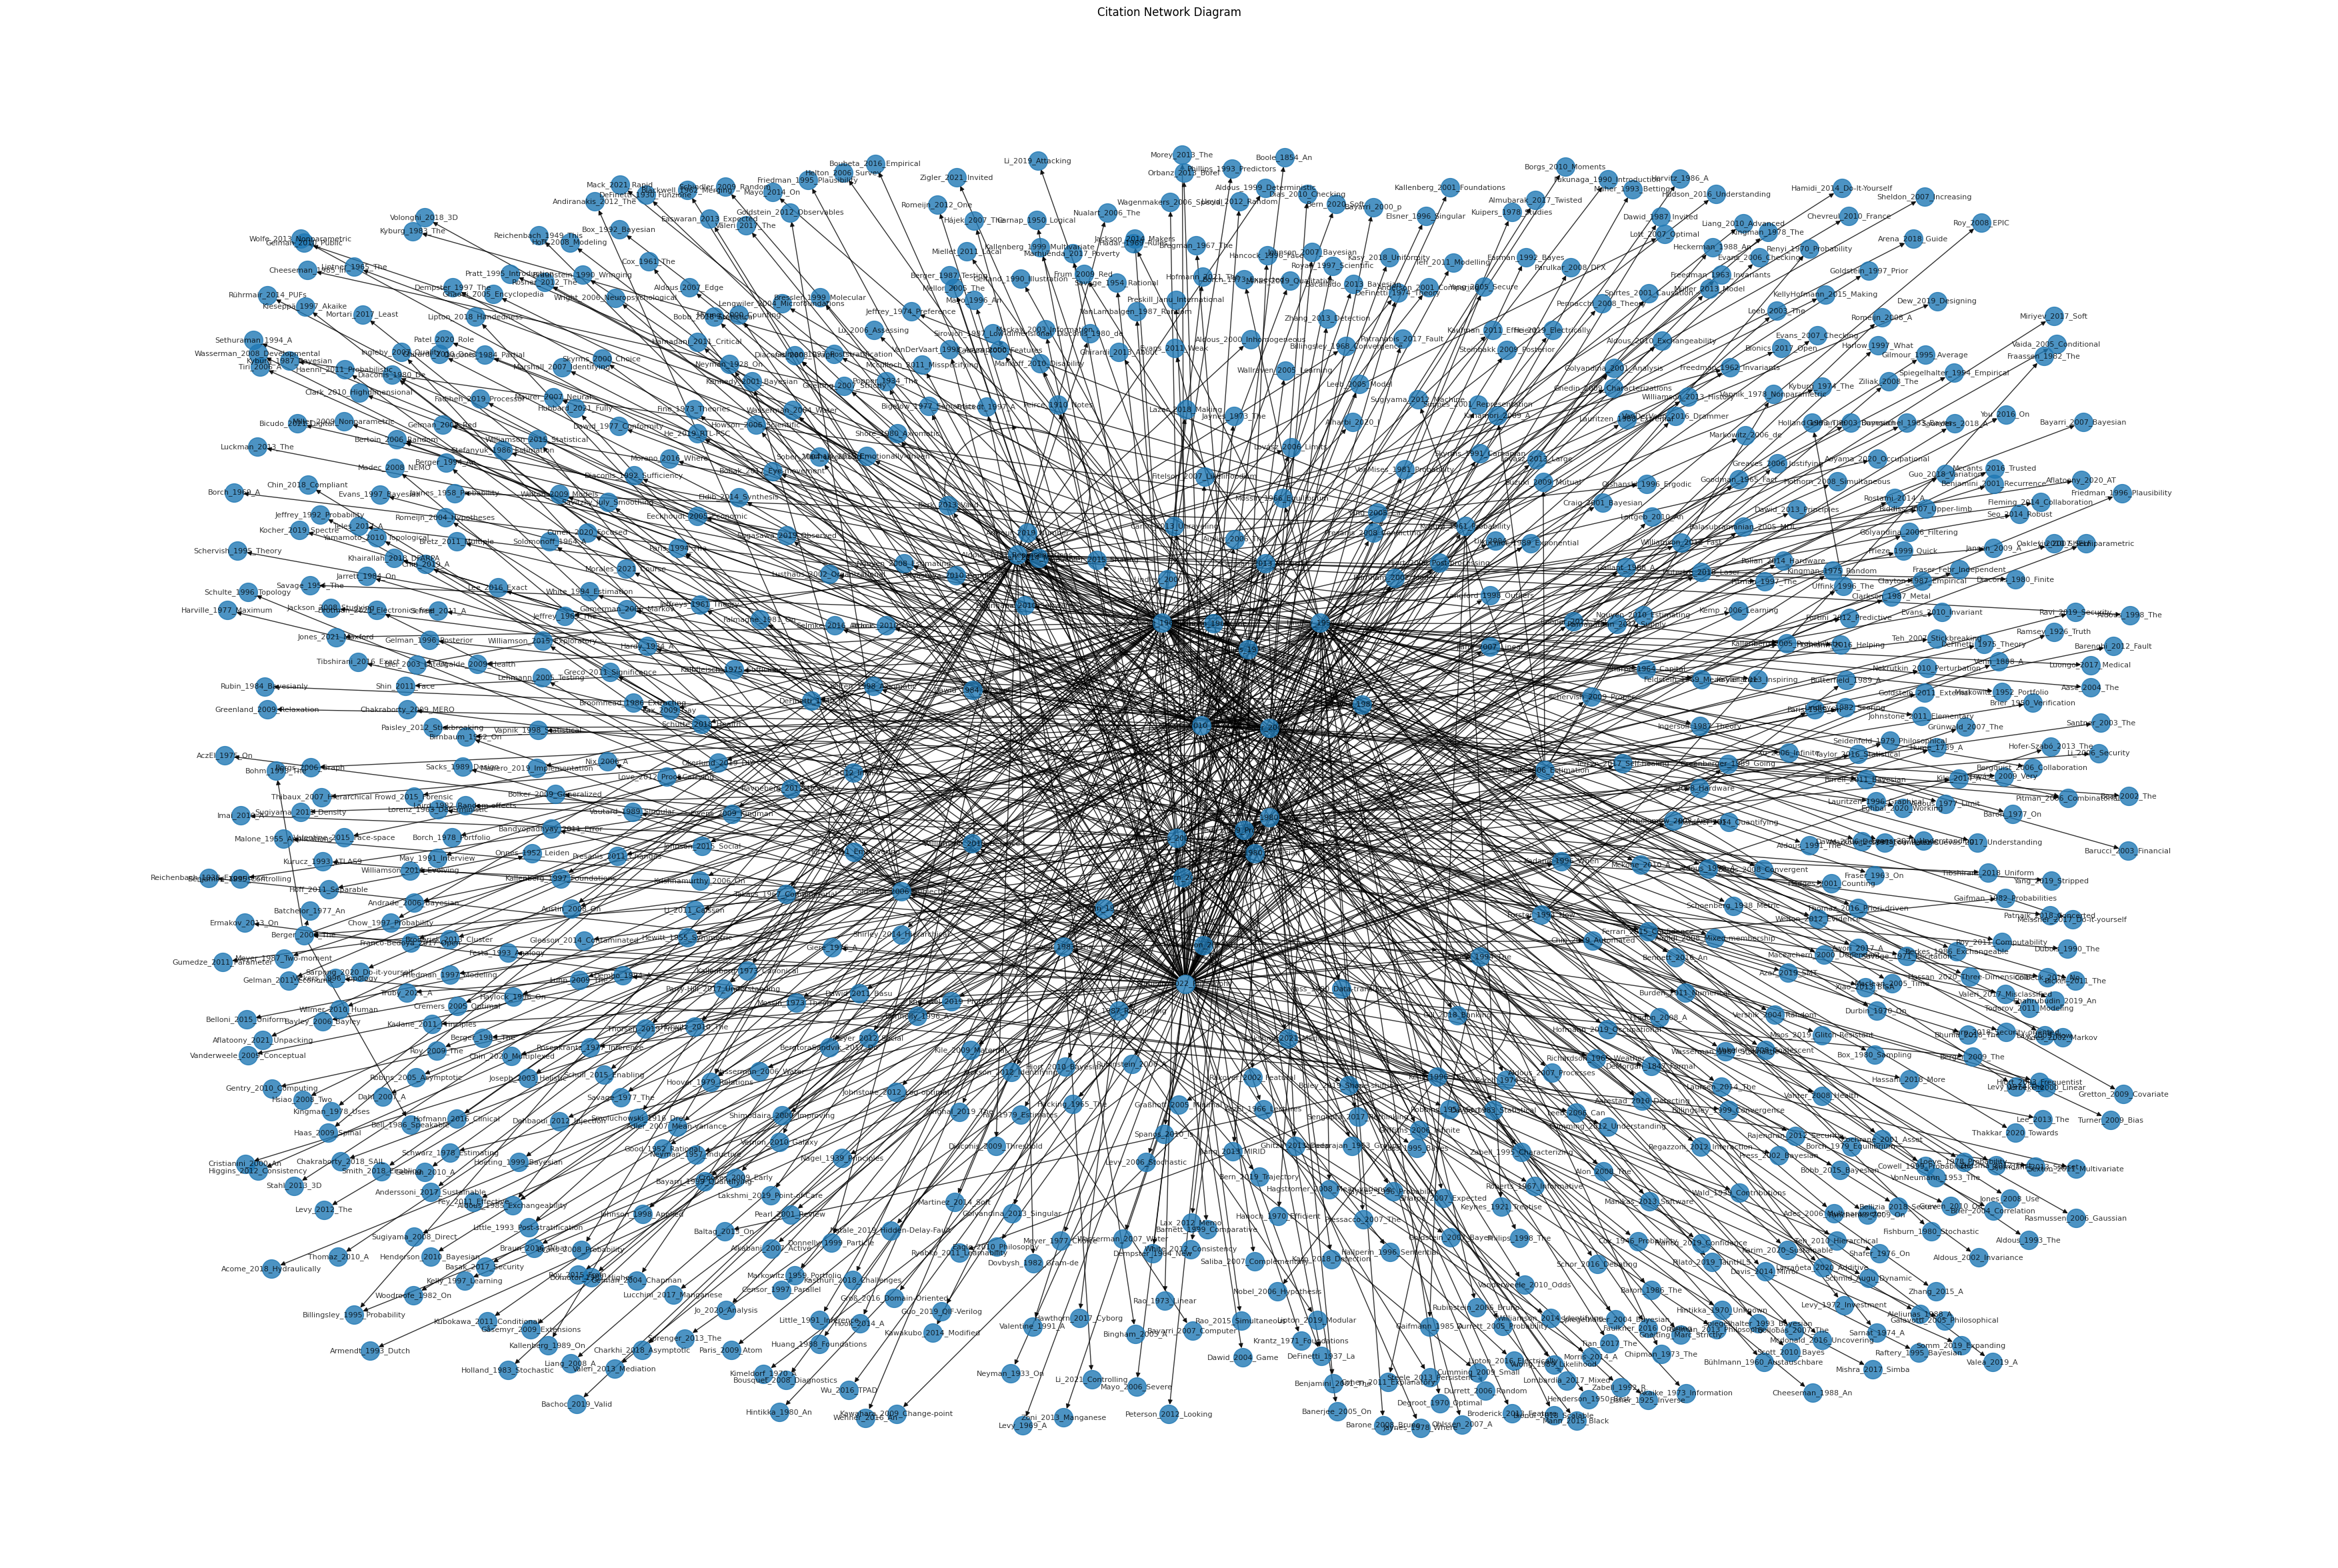

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
conn = mariadb.connect(
    user="root",
    password="sr",
    host="localhost",
    database="corpora",
    port=3306
)

cursor = conn.cursor()
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3

# Fetch the data from the SQL table
cursor.execute('SELECT text_id_cites, text_id_cited FROM citations')
rows = cursor.fetchall()

# Create an empty graph
citation_graph = nx.DiGraph()

# Iterate over the rows and add edges to the graph
for row in rows:
    text_id_cites, text_id_cited = row
    citation_graph.add_edge(text_id_cites, text_id_cited)

# Close the database connection
conn.close()

# Generate the citation network diagram with Fruchterman-Reingold layout
plt.figure(figsize=(45, 30))
pos = nx.spring_layout(citation_graph, k=0.05, iterations=3)  # Adjust 'k' and 'iterations' as needed
nx.draw_networkx(citation_graph, pos, with_labels=True, node_size=400, alpha=0.8, font_size=8)
plt.title('Citation Network Diagram')
plt.axis('off')
plt.show()
